In [1]:
from matplotlib import pyplot as plt
import zipfile
import tempfile
import requests
import os
import numpy as np
import pandas as pd

In [62]:
#GLOBAL
SELECT_ALL_QUESTIONS = ['SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SPNDSRC8']
sa_strs = ['PSWHYCHG','INTRNT','ENROLL','SSAPGM','WHYCHNGD','PSPLANS','TEACH','SSAEXPCT','SPNDSRC','PSCHNG','COMP',
           'CHNGHOW', 'FOODSUFRSN', 'SNAPMNTH','WHEREFREE']
def get_puf_data(first_week, last_week):
    '''
    download puf files for the given weeks and concatenate the datasets
    '''
    df = pd.DataFrame()
    for i in range(first_week,last_week+1):
        y = 2020
        if i>=22:
            y=2021
        file_str = "pulse{}_puf_{}.csv".format(y,i)
        url_str = "https://www2.census.gov/programs-surveys/demo/datasets/hhp/{yr}/wk{w}/HPS_Week{w}_PUF_CSV.zip".format(yr=y,w=i)
        week_df = download_url(url_str, file_str, y, i)
        df = pd.concat([df,week_df])

    return df


def download_url(url_str,file_str, year, week, chunk_size=128):
    '''
    download puf, avoid intermediate save to disk
    '''
    df = pd.DataFrame()
    r = requests.get(url_str)
    print(r)
    #temp directory rather than file to hopefully accomodate windows users
    with tempfile.TemporaryDirectory() as td:
        f_name = os.path.join(td, 'week_{}'.format(week))
        with open(f_name, 'wb') as fh:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fh.write(chunk)
        zf = zipfile.ZipFile(f_name)
        df = pd.read_csv(zf.open(file_str))
        df1 = pd.read_csv(zf.open("pulse{}_repwgt_puf_{}.csv".format(year,week)))
        zf.close()
        r.close()

    return pd.merge(df,df1,on=["SCRAM","WEEK"],how="inner")


def get_std_err(df, weight):
    #make 1d array of weight col
    obs_wgts = df[weight].to_numpy().reshape(len(df),1)
    
    #make 80d array of replicate weights
    rep_wgts = df[[i for i in df.columns if weight in i and not i == weight]].to_numpy()
    
    #return standard error of estimate
    return np.sqrt((np.sum(np.square(rep_wgts-obs_wgts),axis=1)*(4/80)))
############

def freq_crosstab(df, col_list, weight, critical_val=1):
    '''

    '''
    
    pt_estimates = df.groupby(col_list, as_index=True)[[i for i in df.columns if weight in i]].agg('sum')
    pt_estimates['std_err'] = get_std_err(pt_estimates, weight)
    pt_estimates['mrgn_err'] = pt_estimates.std_err * critical_val

    return pt_estimates[[weight, 'std_err','mrgn_err']].reset_index()

def full_crosstab(df, col_list, weight, proportion_level, critical_val=1):
    df1 = df.copy()
    detail = freq_crosstab(df1, col_list, weight, critical_val)
    top = freq_crosstab(df1, proportion_level, weight, critical_val)
    
    rv = detail.merge(top,'left',proportion_level,suffixes=('_full','_demo'))
    rv['proportions'] = rv[weight+'_full']/rv[weight+'_demo']
    return rv

def bulk_crosstabs(df, idx_list, ct_list, q_list, weight='PWEIGHT', critical_val=1):
    rv = pd.DataFrame()
    input_df = df.copy()
    full_selectall = [i for i in input_df.columns if i[:-1] in sa_strs and i[-1].isdigit()]
    input_df[full_selectall] = input_df[full_selectall].replace('-99','0 - not selected')
    input_df.replace(['-88','-99',-88,-99],np.nan,inplace=True)
    for ct in ct_list:
        for q in q_list:
            full = idx_list + [ct, q]
            abstract = idx_list + [ct]
            temp = input_df[-input_df[full].isna().any(axis=1)]
            if q[:-1] in sa_strs:
                print(temp.shape)
                all_q = [i for i in full_selectall if q[:-1] in i]
                print(sel_all)
                temp = temp[-(temp[all_q].iloc[:,:]=='0 - not selected').all(1)]
                print(temp.shape)
            curr_bin = full_crosstab(temp,full,
                            weight,
                            abstract,
                            critical_val=critical_val)
            curr_bin.rename(columns={q:'q_val',ct:'ct_val'},inplace=True)
            curr_bin['ct_var'] = ct
            curr_bin['q_var'] = q
            rv = pd.concat([rv,curr_bin])
    return rv
#a = (check[sel_all].iloc[:,:]=='-99').all(1)
#sel_all = [i for i in check.columns if q[:-1] in i and i[-1].isdigit()] #listicle mfer
#a = (check[sel_all].iloc[:,:]=='-99').all(1) #bool list, negate. with imput

In [51]:
core_df = get_puf_data(13,14)

<Response [200]>
<Response [200]>


## Tie Out Housing 1b Table

In [90]:
test_df = core_df[core_df.WEEK==21].copy()
test_df['rent_check'] = test_df.apply(lambda x: 4 if x.TENURE==4 else x.RENTCUR, axis=1)
test_df['race_eth'] = test_df.apply(lambda x: 5 if x.RHISPANIC==2 else x.RRACE, axis=1)
full_crosstab(test_df, ['EGENDER', 'rent_check'], 'PWEIGHT', ['EGENDER'],critical_val=1).round(2)

,EGENDER,rent_check,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions
0,1,-99,65521.28,22916.93,22916.93,120531610.0,0.0,0.0,0.00
1,1,-88,95767609.18,616700.77,616700.77,120531610.0,0.0,0.0,0.79
2,1,1,18984062.29,625926.33,625926.33,120531610.0,0.0,0.0,0.16
3,1,2,4161891.23,265570.79,265570.79,120531610.0,0.0,0.0,0.03
4,1,4,1552526.03,178942.97,178942.97,120531610.0,0.0,0.0,0.01
5,2,-99,52740.11,18792.06,18792.06,128639306.0,0.0,0.0,0.00
6,2,-88,97179048.55,516318.86,516318.86,128639306.0,0.0,0.0,0.76
7,2,1,23721816.46,458667.57,458667.57,128639306.0,0.0,0.0,0.18
8,2,2,5974193.24,289729.34,289729.34,128639306.0,0.0,0.0,0.05
9,2,4,1711507.64,145060.18,145060.18,128639306.0,0.0,0.0,0.01


In [57]:
states = {1:'Alabama',2:'Alaska',4:'Arizona',5:'Arkansas',6:'California',
    8:'Colorado',9:'Connecticut',10:'Delaware',11:'District of Columbia',12:'Florida',
    13:'Georgia',15:'Hawaii',16:'Idaho',17:'Illinois',18:'Indiana',19:'Iowa',20:'Kansas',21:'Kentucky',
    22:'Louisiana',23:'Maine',24:'Maryland',25:'Massachusetts',26:'Michigan',27:'Minnesota',
    28:'Mississippi',29:'Missouri',30:'Montana',31:'Nebraska',32:'Nevada',33:'New Hampshire',
    34:'New Jersey',35:'New Mexico',36:'New York',37:'North Carolina',38:'North Dakota',39:'Ohio',
    40:'Oklahoma',41:'Oregon',42:'Pennsylvania',44:'Rhode Island',45:'South Carolina',
    46:'South Dakota',47:'Tennessee',48:'Texas',49:'Utah',50:'Vermont',51:'Virginia',
    53:'Washington',54:'West Virginia',55:'Wisconsin',56:'Wyoming'}
regions = {1:'NE',2:'S',3:'MW',4:'W'}
#metros = {35620:'New York',31080:'Los Angeles',16980:'Chicago',19100:'Dallas',
#          26420:'Houston',47900:'DC',33100:'Miami',37980:'Philadelphia',
#          12060:'Atlanta',38060:'Phoenix',14460:'Boston',41860:'San Francisco',
#          40140:'Riverside CA',19820:'Detroit',42660:'Seattle'}
races = {1:'white',2:'black',3:'Asian',4:'Other'}
rents = {1:'current',2:'behind'}
df1 = core_df.copy()
#df1['metro'] = df1.EST_MSA.map(metros) 
df1['state'] = df1.EST_ST.map(states)
df1['region'] = df1.REGION.map(regions)
df1['race'] = df1.RRACE.map(races)
df1['rent'] = df1.RENTCUR.map(rents)

In [58]:
df1.head()

,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,...,PWEIGHT75,PWEIGHT76,PWEIGHT77,PWEIGHT78,PWEIGHT79,PWEIGHT80,state,region,race,rent
0,V130000001S12010403200123,13,48,19100.0,2,1276.886650,1278.107099,1989,2,1,...,2257.993256,1304.664787,1472.202234,1233.628436,1196.505058,1215.415277,Texas,S,white,current
1,V130000001S34010154300113,13,1,NaN,2,1195.578846,2323.078960,1988,2,2,...,2112.200451,4424.739847,2455.226408,709.823095,2262.601339,2469.575314,Alabama,S,white,NaN
2,V130000001S37010241600123,13,1,NaN,2,1124.648326,1092.628425,1969,2,1,...,365.222779,1728.445817,1185.078109,1106.212145,1109.858367,941.001202,Alabama,S,black,NaN
3,V130000001S37010645600123,13,1,NaN,2,517.598058,1005.723011,1947,2,1,...,1091.655402,1616.805406,302.113741,991.757210,1901.981145,913.564961,Alabama,S,white,NaN
4,V130000001S70011963510113,13,1,NaN,2,432.646602,840.657411,1968,2,2,...,911.985219,790.218690,260.896944,743.862030,1465.293707,910.277449,Alabama,S,black,NaN


## Metro Evictions, Metro Behind Rent

In [59]:
metro_evict = df1[df1.EVICT>0]
metro_evict['evict_bool'] = metro_evict.apply(lambda x: 1 if x.EVICT<3 else 0,axis=1)
metro_evict_ct = full_crosstab(metro_evict[metro_evict.metro!='remove'],
                         ['WEEK','metro', 'evict_bool'],
                         'PWEIGHT',
                         ['WEEK','metro'],
                         critical_val=1).round(2)
metro_evict_ct[(metro_evict_ct.evict_bool==1)&(metro_evict_ct.metro=='Phoenix')]

AttributeError: 'DataFrame' object has no attribute 'metro'

In [39]:
#add occupied without rent and include with behind? people much more worried about eviction than ppl behind on rent
metro_rent_ct = full_crosstab(df1[-(df1.rent=='remove')],
                         ['WEEK','metro', 'rent'],
                         'PWEIGHT',
                         ['WEEK','metro'],
                         critical_val=1).round(2)
metro_rent_ct[(metro_rent_ct.rent=='behind')&(metro_rent_ct.metro=='Phoenix')]

,WEEK,metro,rent,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions
22,13,Phoenix,behind,102490.28,26782.72,26782.72,737756.09,61180.29,61180.29,0.14
54,14,Phoenix,behind,68365.49,17708.66,17708.66,806460.14,53276.17,53276.17,0.08
86,15,Phoenix,behind,97878.93,27011.71,27011.71,898643.14,59301.43,59301.43,0.11
118,16,Phoenix,behind,94287.97,24035.15,24035.15,786646.34,67281.99,67281.99,0.12
150,17,Phoenix,behind,100013.57,23849.52,23849.52,992940.79,85689.57,85689.57,0.10
182,18,Phoenix,behind,220968.36,71308.08,71308.08,879308.05,107214.54,107214.54,0.25
214,19,Phoenix,behind,115121.44,31379.48,31379.48,816134.71,66145.36,66145.36,0.14
246,20,Phoenix,behind,136012.60,30094.51,30094.51,731107.29,61934.40,61934.40,0.19
278,21,Phoenix,behind,106262.11,26537.86,26537.86,741455.52,71069.38,71069.38,0.14
310,22,Phoenix,behind,109704.60,36972.23,36972.23,750766.92,71089.52,71089.52,0.15


In [200]:
#full_crosstab(df, ['WEEK','metro'], 'PWEIGHT', ['WEEK','metro'], critical_val=1.645).round(2)
df1 = df[df.WEEK==13].copy()
df1 = df1[df1.metro=='Atlanta']
full_crosstab(df1, ['metro','race','rent'], 'PWEIGHT', ['metro','race'], critical_val=1.645).round(2)

,metro,race,rent,PWEIGHT,std_err,mrgn_err,proportions
0,Atlanta,Asian,behind,5923.87,3624.72,5962.66,0.22
1,Atlanta,Asian,current,20534.83,7041.32,11582.98,0.78
2,Atlanta,Other,behind,8375.40,5765.38,9484.05,0.31
3,Atlanta,Other,current,18352.92,6439.09,10592.30,0.69
4,Atlanta,black,behind,84377.39,25286.83,41596.84,0.20
5,Atlanta,black,current,334560.43,52043.74,85611.95,0.80
6,Atlanta,white,behind,32461.67,13918.24,22895.50,0.08
7,Atlanta,white,current,361599.05,46427.68,76373.54,0.92


In [217]:
detail = full_crosstab(df1, ['WEEK','state','race','rent'], 'PWEIGHT', ['WEEK','state','race'], critical_val=1.645).round(2)
top = full_crosstab(df1, ['WEEK','state','race'], 'PWEIGHT', ['WEEK','state'], critical_val=1.645).round(2)
rv = detail.merge(top,'left',['WEEK','state','race'],suffixes=('_full','_demo'))
y = rv[rv.rent=='behind']
y_2 = y[y.proportions_full>0.4]
y_3 = y_2[y_2.PWEIGHT_full>y_2.mrgn_err_full]
y_3.state.unique()


array(['Alabama', 'Iowa', 'North Carolina', 'South Dakota', 'Virginia',
       'Illinois', 'Minnesota', 'New York', 'Ohio', 'Washington',
       'Connecticut', 'Indiana', 'New Mexico', 'Oregon', 'Georgia',
       'Louisiana', 'Maryland', 'Michigan', 'Pennsylvania', 'Wisconsin',
       'Alaska', 'District of Columbia', 'Nevada', 'Tennessee',
       'Mississippi', 'Nebraska', 'Oklahoma', 'Rhode Island',
       'South Carolina', 'Missouri', 'Texas', 'Colorado', 'Delaware',
       'Florida', 'Kentucky', 'Massachusetts', 'Vermont', 'California',
       'Kansas', 'New Jersey', 'Utah'], dtype=object)

In [209]:
detail_r = full_crosstab(df1, ['WEEK','region','race','rent'], 'PWEIGHT', ['WEEK','region','race'], critical_val=1.645).round(2)
top_r = full_crosstab(df1, ['WEEK','region','race'], 'PWEIGHT', ['WEEK','region'], critical_val=1.645).round(2)
rv_r = detail_r.merge(top_r,'left',['WEEK','region','race'],suffixes=('_full','_demo'))
x = rv_r[rv_r.rent=='behind']
x[x.proportions_full>0.4]

,WEEK,region,race,rent,PWEIGHT_full,std_err_full,mrgn_err_full,proportions_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions_demo
172,18,NE,black,behind,857991.48,189038.01,310967.52,0.44,1928187.96,195373.94,321390.14,0.20
292,22,MW,black,behind,733948.69,156260.04,257047.76,0.50,1479393.27,156888.39,258081.41,0.17
298,22,NE,Other,behind,396776.44,110644.16,182009.64,0.57,701300.10,117815.62,193806.69,0.08


## BULK CROSSTABS

In [4]:
check = pd.read_csv('../data/puf_housing_data_remapped_labels.csv')

In [159]:
SELECT_ALL_QUESTIONS = ['SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SPNDSRC8']
index_list = ['EST_MSA', 'WEEK']
crosstab_list = ['RRACE', 'EEDUC', 'INCOME']
question_list = ['SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SPNDSRC8', 'RENTCUR', 'MORTCUR', 'MORTCONF', 'EVICT', 'FORCLOSE']
bulk_crosstabs(check, index_list, crosstab_list, question_list, weight='PWEIGHT', critical_val=1)
# idx one at a time? level of proportions? TODO: Fix proportion calc w/ NA
# -99 is DNR

,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var
0,12060.0,13,1 - White,0 - not selected,550241.01,65737.99,65737.99,2263934.59,81694.78,81694.78,0.24,RRACE,SPNDSRC1
1,12060.0,13,1 - White,1 - Regular income sources,1713693.58,65061.57,65061.57,2263934.59,81694.78,81694.78,0.76,RRACE,SPNDSRC1
2,12060.0,13,2 - Black,0 - not selected,693102.10,65196.48,65196.48,1413499.92,67904.84,67904.84,0.49,RRACE,SPNDSRC1
3,12060.0,13,2 - Black,1 - Regular income sources,720397.82,63839.39,63839.39,1413499.92,67904.84,67904.84,0.51,RRACE,SPNDSRC1
4,12060.0,13,3 - Asian,0 - not selected,66136.81,17408.49,17408.49,176090.67,26180.63,26180.63,0.38,RRACE,SPNDSRC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,47900.0,22,"5 - $75,000 - $99,999",2 - Not very or not at all likely to leave thi...,16516.31,9044.43,9044.43,17980.58,9202.89,9202.89,0.92,INCOME,FORCLOSE
1822,47900.0,22,"6 - $100,000 - $149,999",1 - Somewhat to very likely to leave this home...,2059.88,2109.63,2109.63,25858.64,8915.82,8915.82,0.08,INCOME,FORCLOSE
1823,47900.0,22,"6 - $100,000 - $149,999",2 - Not very or not at all likely to leave thi...,23798.76,8649.52,8649.52,25858.64,8915.82,8915.82,0.92,INCOME,FORCLOSE
1824,47900.0,22,"7 - $150,000 - $199,999",2 - Not very or not at all likely to leave thi...,4492.10,3688.95,3688.95,4492.10,3688.95,3688.95,1.00,INCOME,FORCLOSE


In [45]:
SELECT_ALL_QUESTIONS = ['SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SPNDSRC8']
index_list = ['EST_MSA', 'WEEK']
crosstab_list = ['RRACE']
question_list = ['SPNDSRC1']
bulk_crosstabs(check, index_list, crosstab_list, question_list, weight='PWEIGHT', critical_val=1)

(246097, 331)
['SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SPNDSRC8']
(246097, 331)


,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var
0,12060.0,13,1 - White,0 - not selected,5.502410e+05,65737.985833,65737.985833,2.263935e+06,81694.775349,81694.775349,0.243046,RRACE,SPNDSRC1
1,12060.0,13,1 - White,1 - Regular income sources,1.713694e+06,65061.568135,65061.568135,2.263935e+06,81694.775349,81694.775349,0.756954,RRACE,SPNDSRC1
2,12060.0,13,2 - Black,0 - not selected,6.931021e+05,65196.476828,65196.476828,1.413500e+06,67904.836277,67904.836277,0.490345,RRACE,SPNDSRC1
3,12060.0,13,2 - Black,1 - Regular income sources,7.203978e+05,63839.386808,63839.386808,1.413500e+06,67904.836277,67904.836277,0.509655,RRACE,SPNDSRC1
4,12060.0,13,3 - Asian,0 - not selected,6.613681e+04,17408.494089,17408.494089,1.760907e+05,26180.634753,26180.634753,0.375584,RRACE,SPNDSRC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,47900.0,22,2 - Black,1 - Regular income sources,5.667022e+05,44462.243888,44462.243888,8.926925e+05,54641.574981,54641.574981,0.634823,RRACE,SPNDSRC1
1196,47900.0,22,3 - Asian,0 - not selected,1.184714e+05,27994.878420,27994.878420,3.991707e+05,39457.985186,39457.985186,0.296794,RRACE,SPNDSRC1
1197,47900.0,22,3 - Asian,1 - Regular income sources,2.806993e+05,30547.422788,30547.422788,3.991707e+05,39457.985186,39457.985186,0.703206,RRACE,SPNDSRC1
1198,47900.0,22,4 - Other,0 - not selected,8.444206e+04,26368.667936,26368.667936,2.335206e+05,45197.750246,45197.750246,0.361604,RRACE,SPNDSRC1


In [47]:
check.groupby('RRACE').count()

,Unnamed: 0,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,...,PWEIGHT72,PWEIGHT73,PWEIGHT74,PWEIGHT75,PWEIGHT76,PWEIGHT77,PWEIGHT78,PWEIGHT79,PWEIGHT80,topline
RRACE,,,,,,,,,,,,,,,,,,,,,
1 - White,694746,694746,694746,694746,200611,694746,694746,694746,694746,694746,...,694746,694746,694746,694746,694746,694746,694746,694746,694746,694746
2 - Black,65634,65634,65634,65634,31112,65634,65634,65634,65634,65634,...,65634,65634,65634,65634,65634,65634,65634,65634,65634,65634
3 - Asian,41742,41742,41742,41742,23056,41742,41742,41742,41742,41742,...,41742,41742,41742,41742,41742,41742,41742,41742,41742,41742
4 - Other,42014,42014,42014,42014,12745,42014,42014,42014,42014,42014,...,42014,42014,42014,42014,42014,42014,42014,42014,42014,42014


In [160]:
#check recodes

,Unnamed: 0,SCRAM,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,...,PWEIGHT72,PWEIGHT73,PWEIGHT74,PWEIGHT75,PWEIGHT76,PWEIGHT77,PWEIGHT78,PWEIGHT79,PWEIGHT80,topline
CHNGHOW1,,,,,,,,,,,,,,,,,,,,,
-88,30040,30040,30040,30040,10267,30040,30040,30040,30040,30040,...,30040,30040,30040,30040,30040,30040,30040,30040,30040,30040
-99,368358,368358,368358,368358,105776,368358,368358,368358,368358,368358,...,368358,368358,368358,368358,368358,368358,368358,368358,368358,368358
1 - Shopping more online,445738,445738,445738,445738,151481,445738,445738,445738,445738,445738,...,445738,445738,445738,445738,445738,445738,445738,445738,445738,445738


In [166]:
for i in SELECT_ALL_QUESTIONS:
    print(i, check_1[check_1.TBIRTH_YEAR>2002].groupby(i).count())

SPNDSRC1           Unnamed: 0  SCRAM  WEEK  EST_ST  EST_MSA  REGION  HWEIGHT  PWEIGHT  \
SPNDSRC1                                                                       
-88              319    319   319     319      101     319      319      319   
-99                1      1     1       1        0       1        1        1   

          TBIRTH_YEAR  ABIRTH_YEAR  ...  PWEIGHT72  PWEIGHT73  PWEIGHT74  \
SPNDSRC1                            ...                                    
-88               319          319  ...        319        319        319   
-99                 1            1  ...          1          1          1   

          PWEIGHT75  PWEIGHT76  PWEIGHT77  PWEIGHT78  PWEIGHT79  PWEIGHT80  \
SPNDSRC1                                                                     
-88             319        319        319        319        319        319   
-99               1          1          1          1          1          1   

          topline  
SPNDSRC1           
-88         

In [169]:
check3 = check_1.copy()
for i in SELECT_ALL_QUESTIONS:
    check3 = check3[check3[i]=='-99']
    print(check3.shape)

(186882, 331)
(113552, 331)
(65353, 331)
(49738, 331)
(35743, 331)
(26612, 331)
(24146, 331)
(19987, 331)


In [1]:
#check3[SELECT_ALL_QUESTIONS].head()
check_1.columns

NameError: name 'check_1' is not defined

In [48]:
#for i in ['PSWHYCHG', 'INTRNT', 'ENROLL', 'SSAPGM', 'WHYCHNGD','PSPLANS', 'TEACH', 'SSAEXPCT', 'SPNDSRC', 'PSCHNG', 'COMP',#'CHNGHOW', 'FOODSUFRSN', 'SNAPMNTH', 'WHEREFREE']:
#    print(i)
#    sel_all = [j for j in check.columns if i in j and j[-1].isdigit()]
    #check[sel_all] #df['outcome'] = (df.iloc[:,sel_all] == -99).all(1).astype(int) 
#    a = (check[sel_all].iloc[:,:-1]=='-99').all(1)
sel_all = [j for j in check.columns if 'SPNDSRC' in j and j[-1].isdigit()] #listicle mfer
a = (check[sel_all].iloc[:,:]=='-99').all(1) #bool list, negate. with imput
a1 = check.shape[0]

a2 = check[-a].shape[0]
a1-a2

19987

In [57]:
bulk_crosstabs(check,['WEEK','EST_MSA'],['RRACE'],['SPNDSRC1'])

(246097, 331)
['SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SPNDSRC8']
(239571, 331)


,WEEK,EST_MSA,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var
0,13,12060.0,1 - White,0 - not selected,4.916925e+05,63257.426924,63257.426924,2.205386e+06,81082.374839,81082.374839,0.222951,RRACE,SPNDSRC1
1,13,12060.0,1 - White,1 - Regular income sources,1.713694e+06,65061.568135,65061.568135,2.205386e+06,81082.374839,81082.374839,0.777049,RRACE,SPNDSRC1
2,13,12060.0,2 - Black,0 - not selected,6.246604e+05,65778.489452,65778.489452,1.345058e+06,75194.460125,75194.460125,0.464411,RRACE,SPNDSRC1
3,13,12060.0,2 - Black,1 - Regular income sources,7.203978e+05,63839.386808,63839.386808,1.345058e+06,75194.460125,75194.460125,0.535589,RRACE,SPNDSRC1
4,13,12060.0,3 - Asian,0 - not selected,6.421807e+04,17714.159805,17714.159805,1.741719e+05,26385.049023,26385.049023,0.368705,RRACE,SPNDSRC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,22,47900.0,2 - Black,1 - Regular income sources,5.667022e+05,44462.243888,44462.243888,8.362191e+05,51794.500322,51794.500322,0.677696,RRACE,SPNDSRC1
1196,22,47900.0,3 - Asian,0 - not selected,1.054126e+05,26605.596025,26605.596025,3.861118e+05,37864.096203,37864.096203,0.273010,RRACE,SPNDSRC1
1197,22,47900.0,3 - Asian,1 - Regular income sources,2.806993e+05,30547.422788,30547.422788,3.861118e+05,37864.096203,37864.096203,0.726990,RRACE,SPNDSRC1
1198,22,47900.0,4 - Other,0 - not selected,8.085844e+04,26130.880070,26130.880070,2.299369e+05,45231.681991,45231.681991,0.351655,RRACE,SPNDSRC1


In [55]:
[i for i in check.columns if i[:-1] in sa_strs and i[-1].isdigit()]

['SSAPGM1',
 'SSAPGM2',
 'SSAPGM3',
 'SSAPGM4',
 'SSAPGM5',
 'SSAEXPCT1',
 'SSAEXPCT2',
 'SSAEXPCT3',
 'SSAEXPCT4',
 'SSAEXPCT5',
 'CHNGHOW1',
 'CHNGHOW2',
 'CHNGHOW3',
 'CHNGHOW4',
 'CHNGHOW5',
 'CHNGHOW6',
 'CHNGHOW7',
 'CHNGHOW8',
 'CHNGHOW9',
 'WHYCHNGD1',
 'WHYCHNGD2',
 'WHYCHNGD3',
 'WHYCHNGD4',
 'WHYCHNGD5',
 'WHYCHNGD6',
 'WHYCHNGD7',
 'WHYCHNGD8',
 'WHYCHNGD9',
 'SPNDSRC1',
 'SPNDSRC2',
 'SPNDSRC3',
 'SPNDSRC4',
 'SPNDSRC5',
 'SPNDSRC6',
 'SPNDSRC7',
 'SPNDSRC8',
 'FOODSUFRSN1',
 'FOODSUFRSN2',
 'FOODSUFRSN3',
 'FOODSUFRSN4',
 'FOODSUFRSN5',
 'WHEREFREE1',
 'WHEREFREE2',
 'WHEREFREE3',
 'WHEREFREE4',
 'WHEREFREE5',
 'WHEREFREE6',
 'WHEREFREE7',
 'ENROLL1',
 'ENROLL2',
 'ENROLL3',
 'TEACH1',
 'TEACH2',
 'TEACH3',
 'TEACH4',
 'TEACH5',
 'COMP1',
 'COMP2',
 'COMP3',
 'INTRNT1',
 'INTRNT2',
 'INTRNT3',
 'PSPLANS1',
 'PSPLANS2',
 'PSPLANS3',
 'PSPLANS4',
 'PSPLANS5',
 'PSPLANS6',
 'PSCHNG1',
 'PSCHNG2',
 'PSCHNG3',
 'PSCHNG4',
 'PSCHNG5',
 'PSCHNG6',
 'PSCHNG7',
 'PSWHYCHG1',
 'PSW

In [24]:
SELECT_ALL_QUESTIONS

['SPNDSRC1',
 'SPNDSRC2',
 'SPNDSRC3',
 'SPNDSRC4',
 'SPNDSRC5',
 'SPNDSRC6',
 'SPNDSRC7',
 'SPNDSRC8']

In [39]:
test_output = pd.read_csv('../test_output.csv')

In [63]:
bulk_crosstabs(df1, ['WEEK','EST_MSA'], ['RRACE'], ['EVICT'], weight='PWEIGHT', critical_val=1)

,WEEK,EST_MSA,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var
0,13.0,12060.0,1.0,2.0,2593.387662,2762.455235,2762.455235,23867.212779,11218.197890,11218.197890,0.108659,RRACE,EVICT
1,13.0,12060.0,1.0,3.0,11644.717505,6979.167273,6979.167273,23867.212779,11218.197890,11218.197890,0.487896,RRACE,EVICT
2,13.0,12060.0,1.0,4.0,9629.107612,8515.279590,8515.279590,23867.212779,11218.197890,11218.197890,0.403445,RRACE,EVICT
3,13.0,12060.0,2.0,1.0,17348.077570,8978.636982,8978.636982,84377.392503,25286.829847,25286.829847,0.205601,RRACE,EVICT
4,13.0,12060.0,2.0,2.0,32219.574796,14942.591924,14942.591924,84377.392503,25286.829847,25286.829847,0.381851,RRACE,EVICT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,14.0,47900.0,3.0,4.0,23278.209332,10853.816716,10853.816716,30580.848456,11212.167992,11212.167992,0.761202,RRACE,EVICT
388,14.0,47900.0,4.0,1.0,9402.266435,10713.275482,10713.275482,23427.471304,12822.015821,12822.015821,0.401335,RRACE,EVICT
389,14.0,47900.0,4.0,2.0,7066.505593,7102.422584,7102.422584,23427.471304,12822.015821,12822.015821,0.301633,RRACE,EVICT
390,14.0,47900.0,4.0,3.0,5707.061004,4335.668217,4335.668217,23427.471304,12822.015821,12822.015821,0.243606,RRACE,EVICT


In [56]:
test_output[test_output.q_var=='EVICT'][test_output.ct_var=='RRACE']

,Unnamed: 0,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var
22884,0,12060.0,13,1 - White,1 - Somewhat to very likely to leave home with...,2593.387662,2762.455235,2762.455235,23867.212779,11218.197890,11218.197890,0.108659,RRACE,EVICT
22885,1,12060.0,13,1 - White,2 - Not very or not at all likely to leave hom...,21273.825117,10867.456175,10867.456175,23867.212779,11218.197890,11218.197890,0.891341,RRACE,EVICT
22886,2,12060.0,13,2 - Black,1 - Somewhat to very likely to leave home with...,49567.652365,20435.541008,20435.541008,84377.392503,25286.829847,25286.829847,0.587452,RRACE,EVICT
22887,3,12060.0,13,2 - Black,2 - Not very or not at all likely to leave hom...,34809.740138,15168.795512,15168.795512,84377.392503,25286.829847,25286.829847,0.412548,RRACE,EVICT
22888,4,12060.0,13,3 - Asian,1 - Somewhat to very likely to leave home with...,912.210289,994.932511,994.932511,5923.865074,3624.715566,3624.715566,0.153989,RRACE,EVICT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24254,1370,47900.0,25,2 - Black,1 - Somewhat to very likely to leave home with...,39465.943572,12150.864070,12150.864070,109334.726544,25567.383503,25567.383503,0.360964,RRACE,EVICT
24255,1371,47900.0,25,2 - Black,2 - Not very or not at all likely to leave hom...,69868.782972,21859.913209,21859.913209,109334.726544,25567.383503,25567.383503,0.639036,RRACE,EVICT
24256,1372,47900.0,25,3 - Asian,1 - Somewhat to very likely to leave home with...,11959.841406,8891.493547,8891.493547,16763.548008,9746.233284,9746.233284,0.713443,RRACE,EVICT
24257,1373,47900.0,25,3 - Asian,2 - Not very or not at all likely to leave hom...,4803.706602,4052.070113,4052.070113,16763.548008,9746.233284,9746.233284,0.286557,RRACE,EVICT


In [41]:
dates = pd.read_csv('../data/survey_dates.csv')

In [42]:
dates['date'] = pd.to_datetime(dates[['month','day','year']])

In [43]:
start = test_output.merge(dates[dates.start_end=='start'][['week','date']],how='left',left_on='WEEK',right_on='week')
final = start.merge(dates[dates.start_end=='end'][['week','date']],how='left',left_on='WEEK',right_on='week')

In [46]:
final.drop(columns=['week_x','week_y']).rename(columns={'date_x':'start_date','date_y':'end_date'})

,Unnamed: 0,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var,start_date,end_date
0,0,12060.0,13,1,0 - not selected,1.215987e+06,82111.413916,82111.413916,3.845852e+06,99943.027408,99943.027408,0.316181,TOPLINE,SPNDSRC1,2020-08-19,2020-08-31
1,1,12060.0,13,1,1 - Regular income sources,2.629865e+06,89615.565929,89615.565929,3.845852e+06,99943.027408,99943.027408,0.683819,TOPLINE,SPNDSRC1,2020-08-19,2020-08-31
2,2,12060.0,14,1,0 - not selected,1.175925e+06,94036.495720,94036.495720,4.037202e+06,128272.380630,128272.380630,0.291272,TOPLINE,SPNDSRC1,2020-09-02,2020-09-14
3,3,12060.0,14,1,1 - Regular income sources,2.861277e+06,112729.362279,112729.362279,4.037202e+06,128272.380630,128272.380630,0.708728,TOPLINE,SPNDSRC1,2020-09-02,2020-09-14
4,4,12060.0,15,1,0 - not selected,1.332334e+06,86769.174018,86769.174018,3.938879e+06,101741.495576,101741.495576,0.338252,TOPLINE,SPNDSRC1,2020-09-16,2020-09-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75543,2386,47900.0,25,"5 - $75,000 - $99,999",2 - Not very or not at all likely to leave thi...,1.169549e+04,4220.396101,4220.396101,1.169549e+04,4220.396101,4220.396101,1.000000,INCOME,FORCLOSE,2021-02-17,2021-03-01
75544,2387,47900.0,25,"6 - $100,000 - $149,999",1 - Somewhat to very likely to leave this home...,1.109646e+04,9093.661083,9093.661083,4.748108e+04,12385.560256,12385.560256,0.233703,INCOME,FORCLOSE,2021-02-17,2021-03-01
75545,2388,47900.0,25,"6 - $100,000 - $149,999",2 - Not very or not at all likely to leave thi...,3.638462e+04,10954.103218,10954.103218,4.748108e+04,12385.560256,12385.560256,0.766297,INCOME,FORCLOSE,2021-02-17,2021-03-01
75546,2389,47900.0,25,"7 - $150,000 - $199,999",2 - Not very or not at all likely to leave thi...,2.791065e+04,15488.264310,15488.264310,2.791065e+04,15488.264310,15488.264310,1.000000,INCOME,FORCLOSE,2021-02-17,2021-03-01


In [2]:
raw = pd.read_csv('../analysis/flat_file.csv')

In [3]:
raw.WEEK.unique()

array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [40]:
from googleapiclient.discovery import build
from google.oauth2 import service_account
from pathlib import Path
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
CROSSWALK_SPREADSHEET_ID = '1xrfmQT7Ub1ayoNe05AQAFDhqL7qcKNSW6Y7XuA8s8uo'
CROSSWALK_SHEET_NAMES = ['question_mapping', 'response_mapping', 'county_metro_state', 'flat_file']
root = Path.cwd()

data_dir = root/"data"
data_dir.mkdir(exist_ok=True)

service_account_file = "../credentials.json"

In [41]:
creds = service_account.Credentials.from_service_account_file(service_account_file, scopes=SCOPES)
service = build('sheets', 'v4', credentials=creds)
sheet = service.spreadsheets()
result_input = sheet.values().batchGet(spreadsheetId=CROSSWALK_SPREADSHEET_ID,
                                ranges=CROSSWALK_SHEET_NAMES).execute()

In [38]:
#spreadsheet_id = 'my-spreadsheet-id'  # TODO: Update placeholder value.

batch_update_values_request_body = {
    # How the input data should be interpreted.
    'value_input_option': 'string',  # TODO: Update placeholder value.

    # The new values to apply to the spreadsheet.
    'data': [{i:put_g[i].to_dict()} for i in put_g.columns]
}

request = sheet.values().batchUpdate(spreadsheetId=CROSSWALK_SPREADSHEET_ID,
                                                      ranges='flat_file',
                                                      body=batch_update_values_request_body)
response = request.execute()

# TODO: Change code below to process the `response` dict:
#pprint(response)

TypeError: Got an unexpected keyword argument "ranges"

In [19]:
put_g = raw.drop(columns='Unnamed: 0')

In [43]:
def export_to_sheets(df,workbook_id, sheet_name):
    response_date = service.spreadsheets().values().update(
        spreadsheetId=workbook_id,
        valueInputOption='RAW',
        range=sheet_name,
        body=dict(
            majorDimension='ROWS',
            values=df.T.reset_index().T.values.tolist())
    ).execute()
export_to_sheets(put_g,'flat_file')

In [148]:
raw = pd.read_csv('../data/crosstabs.csv')
test = raw[(raw.q_var == 'RENTCUR') & (raw.ct_var=='TOPLINE') & (raw.EST_MSA==12060) & (raw.q_val=='2 - Not currently caught up on rent')]
x = test.WEEK
y = test.proportions

In [53]:
import pymc3 as pm

from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize
from theano import shared
import numpy as np
import scipy.stats as stats

%pylab inline
figsize(12, 6);

Populating the interactive namespace from numpy and matplotlib


In [54]:
LARGE_NUMBER = 1e5

model = pm.Model()
with model:
    smoothing_param = shared(0.9)
    mu = pm.Normal("mu", sigma=LARGE_NUMBER)
    tau = pm.Exponential("tau", 1.0 / LARGE_NUMBER)
    z = GaussianRandomWalk("z", mu=mu, tau=tau / (1.0 - smoothing_param), shape=y.shape)
    obs = pm.Normal("obs", mu=z, tau=tau / smoothing_param, observed=y)

In [55]:
def infer_z(smoothing):
    with model:
        smoothing_param.set_value(smoothing)
        res = pm.find_MAP(vars=[z], fmin=optimize.fmin_l_bfgs_b)
        return res["z"]

In [56]:
fig, axes = subplots(2, 2)

for ax, smoothing in zip(axes.ravel(), [0.95, 0.99, 0.999, 0.9999]):

    z_val = infer_z(smoothing)

    ax.plot(x, y)
    ax.plot(x, z_val)
    ax.set_title(f"Smoothing={smoothing:05.4f}")

Populating the interactive namespace from numpy and matplotlib


In [94]:
from bs4 import BeautifulSoup
def get_puf_data(first_week, last_week):
    '''
    download puf files for the given weeks and concatenate the datasets
    '''
    df = pd.DataFrame()
    for i in range(first_week,last_week+1):
        y = 2020
        if i>=22:
            y=2021
        file_str = "pulse{}_puf_{}.csv".format(y,i)
        url_str = "https://www2.census.gov/programs-surveys/demo/datasets/hhp/{yr}/wk{w}/HPS_Week{w}_PUF_CSV.zip".format(yr=y,w=i)
        week_df = download_url(url_str, file_str, y, i)
        df = pd.concat([df,week_df])

    return df


def download_url(url_str,file_str, year, week, chunk_size=128):
    '''
    download puf, avoid intermediate save to disk
    '''
    df = pd.DataFrame()
    r = requests.get(url_str)
    print(r)
    #temp directory rather than file to hopefully accomodate windows users
    with tempfile.TemporaryDirectory() as td:
        f_name = os.path.join(td, 'week_{}'.format(week))
        with open(f_name, 'wb') as fh:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fh.write(chunk)
        zf = zipfile.ZipFile(f_name)
        df = pd.read_csv(zf.open(file_str))
        df1 = pd.read_csv(zf.open("pulse{}_repwgt_puf_{}.csv".format(year,week)))
        zf.close()
        r.close()

    return pd.merge(df,df1,on=["SCRAM","WEEK"],how="inner")


def get_std_err(df, weight):
    #make 1d array of weight col
    obs_wgts = df[weight].to_numpy().reshape(len(df),1)
    
    #make 80d array of replicate weights
    rep_wgts = df[[i for i in df.columns if weight in i and not i == weight]].to_numpy()
    
    #return standard error of estimate
    return np.sqrt((np.sum(np.square(rep_wgts-obs_wgts),axis=1)*(4/80)))


def week_mapper():
    URL = 'https://www.census.gov/programs-surveys/household-pulse-survey/data.html'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    week_dict = {}
    for i in soup.find_all("p", class_="uscb-margin-TB-02 uscb-title-3"):
        label = i.text.strip('\n\t\t\t')
        if 'Week' in label:
            kv_pair = label.split(':')
            week_int = int(re.sub("[^0-9]", "", kv_pair[0]))
            if week_int > 21:
                dates = kv_pair[1][1:] + ' 2021'
            else:
                dates = kv_pair[1][1:] + ' 2020'
            week_dict[week_int] = dates
    return week_dict
raw['collection_dates'] = raw.WEEK.map(week_mapper())


,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var,cbsa_title,description_recode,collection_dates
0,12060,13,1,0 - not selected,1.215987e+06,82111.413916,82111.413916,3.845852e+06,99943.027408,99943.027408,0.316181,TOPLINE,SPNDSRC1,"Atlanta-Sandy Springs-Alpharetta, GA",Sources of income and funds for household spen...,August 19 – August 31 2020
1,12060,13,1,1 - Regular income sources,2.629865e+06,89615.565929,89615.565929,3.845852e+06,99943.027408,99943.027408,0.683819,TOPLINE,SPNDSRC1,"Atlanta-Sandy Springs-Alpharetta, GA",Sources of income and funds for household spen...,August 19 – August 31 2020
2,12060,14,1,0 - not selected,1.175925e+06,94036.495720,94036.495720,4.037202e+06,128272.380630,128272.380630,0.291272,TOPLINE,SPNDSRC1,"Atlanta-Sandy Springs-Alpharetta, GA",Sources of income and funds for household spen...,September 2 – September 14 2020
3,12060,14,1,1 - Regular income sources,2.861277e+06,112729.362279,112729.362279,4.037202e+06,128272.380630,128272.380630,0.708728,TOPLINE,SPNDSRC1,"Atlanta-Sandy Springs-Alpharetta, GA",Sources of income and funds for household spen...,September 2 – September 14 2020
4,12060,15,1,0 - not selected,1.332334e+06,86769.174018,86769.174018,3.938879e+06,101741.495576,101741.495576,0.338252,TOPLINE,SPNDSRC1,"Atlanta-Sandy Springs-Alpharetta, GA",Sources of income and funds for household spen...,September 16 – September 28 2020


In [77]:
#<p class="uscb-margin-TB-02 uscb-title-3">
#			Week 27 Household Pulse Survey: March 17 – March 29
def collect_weeks():
x = []
for i in soup.find_all("p", class_="uscb-margin-TB-02 uscb-title-3"):
    if 'Week' in i.text:
        x.append(i.text.strip('\n\t\t\t'))
x

['Week 27 Household Pulse Survey: March 17 – March 29',
 'Week 26 Household Pulse Survey: March 3 – March 15',
 'Week 25 Household Pulse Survey: February 17 – March 1',
 'Week 24 Household Pulse Survey: February 3 – February 15',
 'Week 23 Household Pulse Survey: January 20 – February 1',
 'Week 22 Household Pulse Survey: January 6 – January 18',
 'Week 21 Household Pulse Survey: December 9 – December 21',
 'Week 20 Household Pulse Survey: November 25 – December 7',
 'Week 19 Household Pulse Survey: November 11 – November 23',
 'Week 18 Household Pulse Survey: October 28 – November 9',
 'Week 17 Household Pulse Survey: October 14 – October 26',
 'Week 16 Household Pulse Survey: September 30 – October 12',
 'Week 15 Household Pulse Survey: September 16 – September 28',
 'Week 14 Household Pulse Survey: September 2 – September 14',
 'Week 13 Household Pulse Survey: August 19 – August 31',
 'Week 12 Household Pulse Survey:  July 16 - July 21',
 'Week 11 Household Pulse Survey:  July 9 - J

In [70]:
soup.find_all('div', attrs={'class' : "listContent "})

[]

In [84]:
type(raw.WEEK[0])

numpy.int64

In [95]:
print(bs4.__version__)

NameError: name 'bs4' is not defined

In [96]:
import pymc3 as pm
import numpy as np
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize, stats
from theano import shared

Text(0.5, 1.0, 'Observed Data')

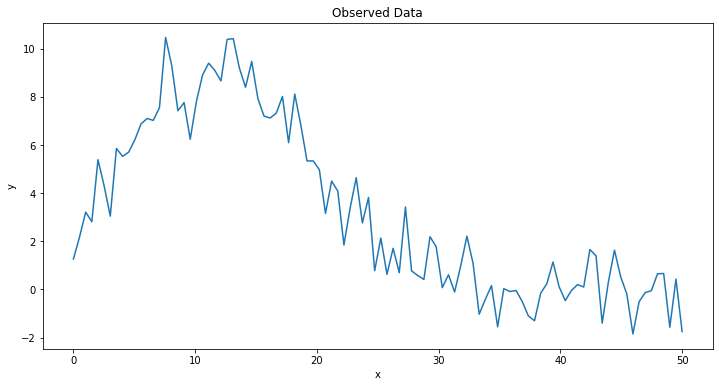

In [98]:
x = np.linspace(0, 50, 100)
y = np.exp(1.0 + np.power(x, 0.5) - np.exp(x / 15.0)) + np.random.normal(scale=1.0, size=x.shape)

plot(x, y)
xlabel("x")
ylabel("y")
title("Observed Data")

In [99]:
LARGE_NUMBER = 1e5

model = pm.Model()
with model:
    smoothing_param = shared(0.9)
    mu = pm.Normal("mu", sigma=LARGE_NUMBER)
    tau = pm.Exponential("tau", 1.0 / LARGE_NUMBER)
    z = GaussianRandomWalk("z", mu=mu, tau=tau / (1.0 - smoothing_param), shape=y.shape)
    obs = pm.Normal("obs", mu=z, tau=tau / smoothing_param, observed=y)

In [100]:
def infer_z(smoothing):
    with model:
        smoothing_param.set_value(smoothing)
        res = pm.find_MAP(vars=[z], fmin=optimize.fmin_l_bfgs_b)
        return res["z"]


In [2]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import seaborn as sns

In [115]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(np.array(x).reshape(len(x),1), y)

GaussianProcessRegressor(kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1))

In [116]:
x.shape

(13,)

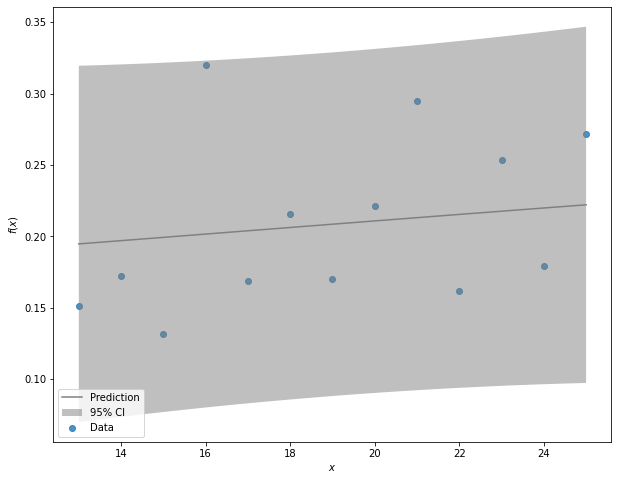

In [122]:
plt.figure(figsize=(10,8))
sns.regplot(x, y, fit_reg=False, label='Data')
plt.plot(x_pred, y_pred, color='grey', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([y_pred - 2*sigma,
                        (y_pred + 2*sigma)[::-1]]),
         alpha=.5, fc='grey', ec='None', label='95% CI')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='lower left');

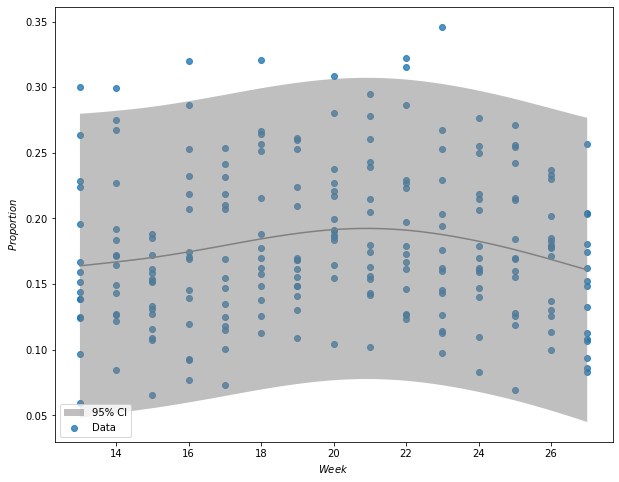

In [15]:
raw = pd.read_csv('../data/crosstabs.csv')

#for i in raw.EST_MSA.unique():
#    test = raw[(raw.q_var == 'RENTCUR') & (raw.ct_var=='TOPLINE') & (raw.EST_MSA==i) & (raw.q_val=='2 - Not currently caught up on rent')]
#    x = test.WEEK
#    y = test.proportions

def gp(df, ct_var, q_var, q_val, plot=True):
        work_df = df[(df.q_var == q_var) & (df.ct_var==ct_var) & (df.q_val==q_val)]
        x = work_df.WEEK
        y = work_df.proportions
        kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=0.5)
        gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
        gp.fit(np.array(x).reshape(len(x),1), y)

        x_pred = np.linspace(work_df.WEEK.min(), work_df.WEEK.max()).reshape(-1,1)
        y_pred, sigma = gp.predict(x_pred, return_std=True)
        if not plot:
                return x_pred, y_pred, sigma
        plt.figure(figsize=(10,8))
        sns.regplot(x, y, fit_reg=False, label='Data')
        plt.plot(x_pred, y_pred, color='grey')
        plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
                np.concatenate([y_pred - 2*sigma,
                (y_pred + 2*sigma)[::-1]]),
                alpha=.5, fc='grey', ec='None', label='95% CI')
        plt.xlabel('$Week$')
        plt.ylabel('$Proportion$')
        plt.legend(loc='lower left')

gp(raw, 'TOPLINE', 'RENTCUR','2 - Not currently caught up on rent',plot=True)

In [124]:
test.head()

,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var,cbsa_title,description_recode,collection_dates
51596,47900,13,1,2 - Not currently caught up on rent,157980.108793,25542.014243,25542.014243,1.136709e+06,76655.351403,76655.351403,0.138980,TOPLINE,RENTCUR,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Whether household is currently caught up on re...,August 19 – August 31 2020
51598,47900,14,1,2 - Not currently caught up on rent,210606.056746,32287.400587,32287.400587,1.144682e+06,58966.549994,58966.549994,0.183986,TOPLINE,RENTCUR,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Whether household is currently caught up on re...,September 2 – September 14 2020
51600,47900,15,1,2 - Not currently caught up on rent,207480.400674,39673.270309,39673.270309,1.100742e+06,60146.454667,60146.454667,0.188491,TOPLINE,RENTCUR,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Whether household is currently caught up on re...,September 16 – September 28 2020
51602,47900,16,1,2 - Not currently caught up on rent,153017.361310,29593.715623,29593.715623,1.099920e+06,59615.561590,59615.561590,0.139117,TOPLINE,RENTCUR,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Whether household is currently caught up on re...,September 30 – October 12 2020
51604,47900,17,1,2 - Not currently caught up on rent,120545.270306,22461.490657,22461.490657,1.019577e+06,63413.530948,63413.530948,0.118231,TOPLINE,RENTCUR,"Washington-Arlington-Alexandria, DC-VA-MD-WV",Whether household is currently caught up on re...,October 14 – October 26 2020


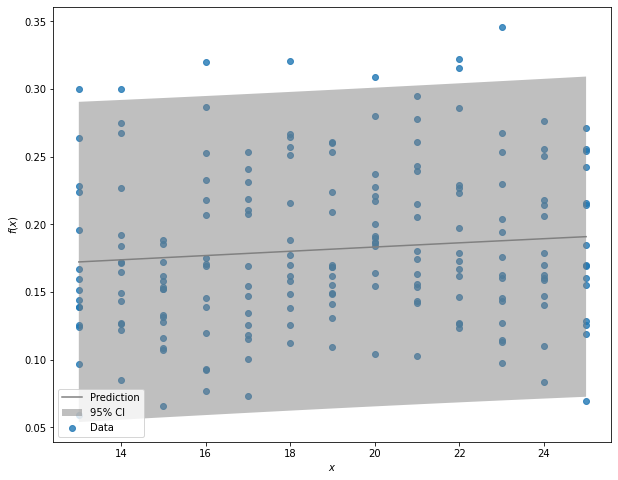

In [128]:
test = raw[(raw.q_var == 'RENTCUR') & (raw.ct_var=='TOPLINE') & (raw.q_val=='2 - Not currently caught up on rent')]
x = test.WEEK
y = test.proportions
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(np.array(x).reshape(len(x),1), y)

x_pred = np.linspace(13, 25).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
print()
plt.figure(figsize=(10,8))
sns.regplot(x, y, fit_reg=False, label='Data')
plt.plot(x_pred, y_pred, color='grey', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
        np.concatenate([y_pred - 2*sigma,
                        (y_pred + 2*sigma)[::-1]]),
        alpha=.5, fc='grey', ec='None', label='95% CI')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='lower left');

In [133]:
    index_list = ['EST_MSA', 'WEEK']
    crosstab_list = ['TOPLINE', 'RRACE', 'EEDUC', 'INCOME']
    df = pd.read_csv('../data/puf_housing_data_remapped_labels.csv')
    #[i if i not in index_list+crosstab_list for i in raw.columns]
    

In [141]:
question_list = []
exclude = ['SCRAM', 'EST_ST', 'REGION','TBIRTH_YEAR','ABIRTH_YEAR','EGENDER','AGENDER','RHISPANIC','AHISPANIC','ARACE','AEDUC']
for i in df.columns:
    if i not in index_list+exclude+crosstab_list and 'WEIGHT' not in i:
        question_list.append(i)
question_list

['MS',
 'THHLD_NUMPER',
 'AHHLD_NUMPER',
 'THHLD_NUMKID',
 'AHHLD_NUMKID',
 'THHLD_NUMADLT',
 'WRKLOSS',
 'EXPCTLOSS',
 'ANYWORK',
 'KINDWORK',
 'RSNNOWRK',
 'TW_START',
 'UNEMPPAY',
 'UI_APPLY',
 'UI_RECV',
 'TUI_NUMPER',
 'SSA_RECV',
 'SSA_APPLY',
 'SSAPGM1',
 'SSAPGM2',
 'SSAPGM3',
 'SSAPGM4',
 'SSAPGM5',
 'SSALIKELY',
 'SSAEXPCT1',
 'SSAEXPCT2',
 'SSAEXPCT3',
 'SSAEXPCT4',
 'SSAEXPCT5',
 'SSADECISN',
 'EXPNS_DIF',
 'CHNGHOW1',
 'CHNGHOW2',
 'CHNGHOW3',
 'CHNGHOW4',
 'CHNGHOW5',
 'CHNGHOW6',
 'CHNGHOW7',
 'CHNGHOW8',
 'CHNGHOW9',
 'CHNGHOW10',
 'CHNGHOW11',
 'CHNGHOW12',
 'WHYCHNGD1',
 'WHYCHNGD2',
 'WHYCHNGD3',
 'WHYCHNGD4',
 'WHYCHNGD5',
 'WHYCHNGD6',
 'WHYCHNGD7',
 'WHYCHNGD8',
 'WHYCHNGD9',
 'WHYCHNGD10',
 'WHYCHNGD11',
 'WHYCHNGD12',
 'WHYCHNGD13',
 'SPNDSRC1',
 'SPNDSRC2',
 'SPNDSRC3',
 'SPNDSRC4',
 'SPNDSRC5',
 'SPNDSRC6',
 'SPNDSRC7',
 'SPNDSRC8',
 'FEWRTRIPS',
 'FEWRTRANS',
 'PLNDTRIPS',
 'CNCLDTRPS',
 'PRIFOODSUF',
 'CURFOODSUF',
 'CHILDFOOD',
 'FOODSUFRSN1',
 'FOODSUFRSN2

In [143]:
import statsmodels


In [17]:
import pandas as pd               # Pandas handles dataframes
import numpy as np
import scipy
import matplotlib                 # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
import statsmodels

np.random.seed(10)
test = raw[(raw.q_var == 'RENTCUR') & (raw.ct_var=='TOPLINE') & (raw.q_val=='2 - Not currently caught up on rent')]

x_values = test.WEEK
y_values = test.proportions
df = pd.DataFrame({"Xvalue" : x_values,
                    "Yvalue" : y_values
                    })






In [19]:
def loc_eval(x, b):
    loc_est = 0
    for i in enumerate(b): 
        loc_est+=i[1]*(x**i[0])
    return(loc_est)


def loess(xvals, yvals, data, alpha, poly_degree=1):
    '''
    Returns smoothed values, dataframe must be processes
    '''
    all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)
    evalDF = pd.DataFrame(columns=['v','g'])
    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = min(xvals)-(.5*avg_interval)
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T
    for i in v:
        iterpos = i[0]
        iterval = i[1]
        iterdists = sorted([(j, np.abs(j-iterval)) for j in xvals], key=lambda x: x[1])
        _, raw_dists = zip(*iterdists)
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 if j[1]<=1 else 0)) for j in scaled_dists]
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))
        W         = np.diag(weights)
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ yvals)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })
        evalDF = pd.concat([evalDF, iterDF2])
    evalDF = evalDF[['v','g']]
    return evalDF


evalDF = loess("Xvalue", "Yvalue", data = df, alpha=0.5, poly_degree=2)
evalDF

,v,g
0,12.968889,0.172282
0,13.031388,0.171666
0,13.093886,0.171071
0,13.156385,0.170497
0,13.218884,0.169944
...,...,...
0,26.781116,0.154849
0,26.843615,0.153773
0,26.906114,0.152675
0,26.968612,0.151555


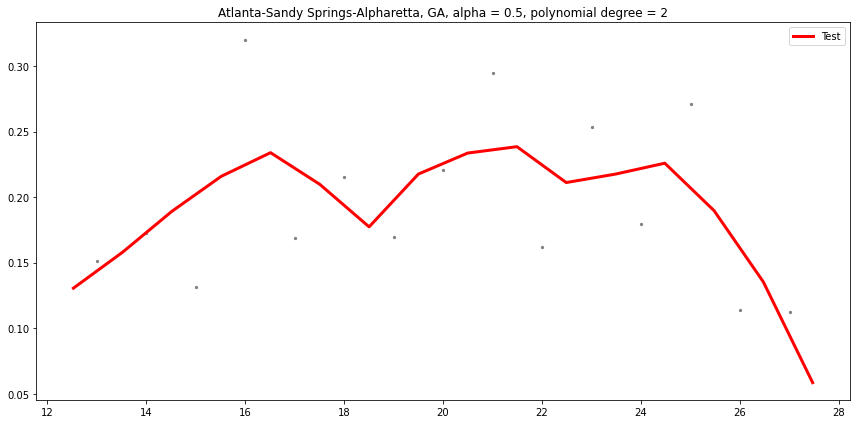

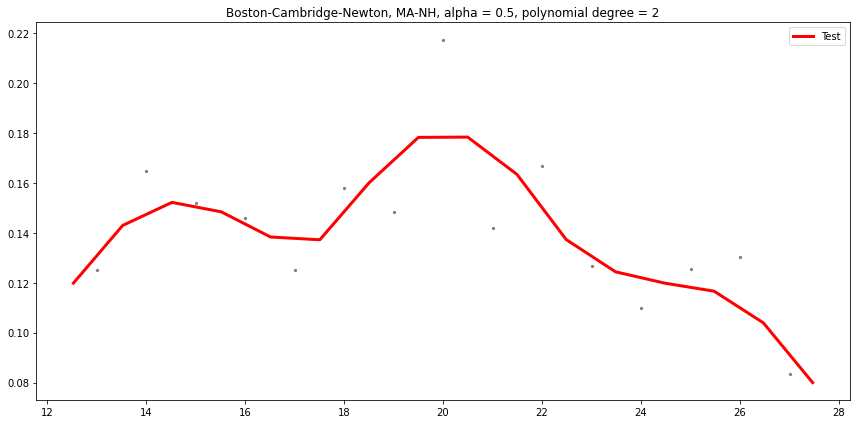

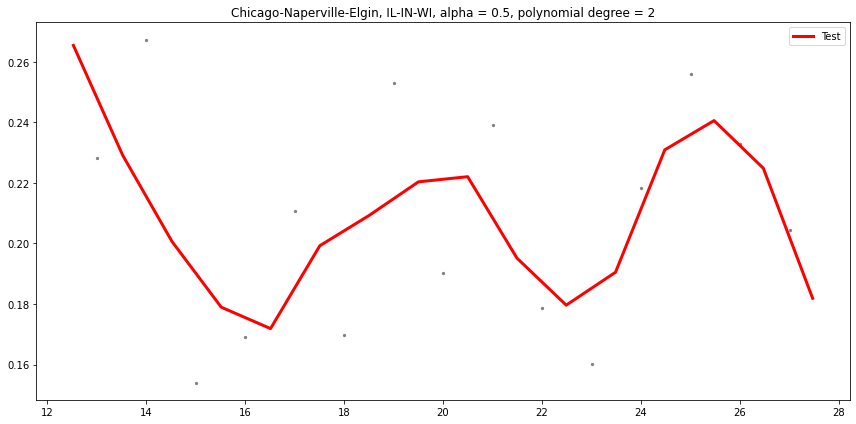

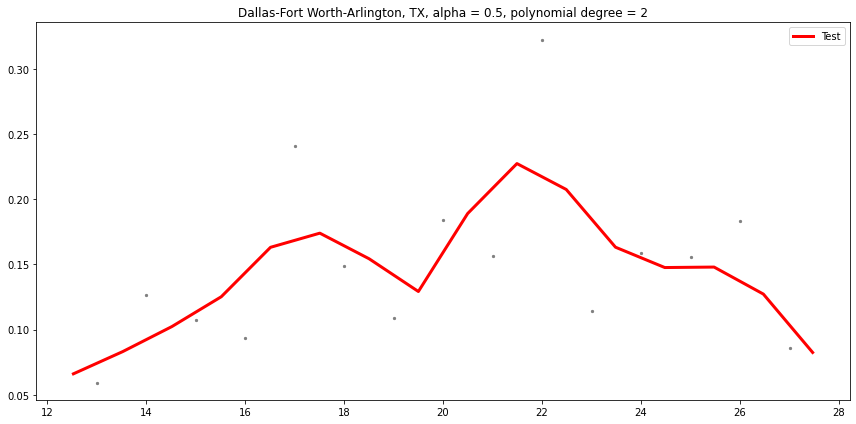

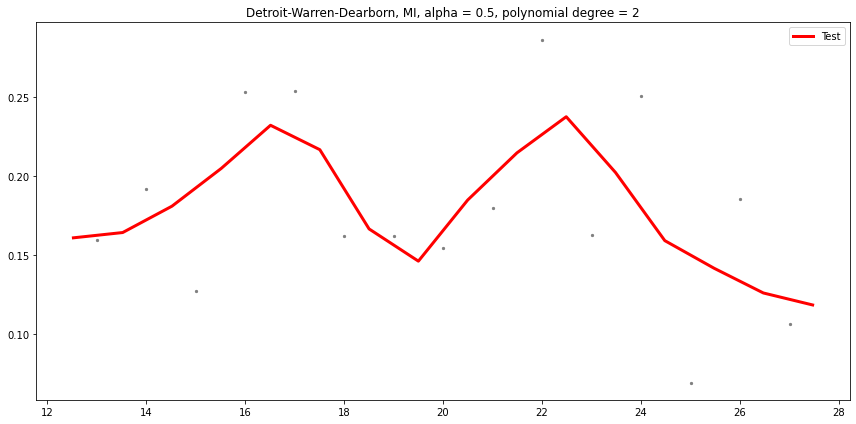

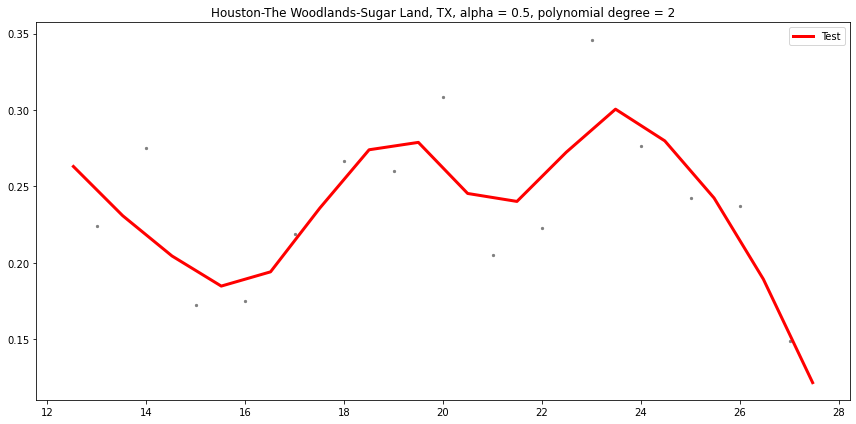

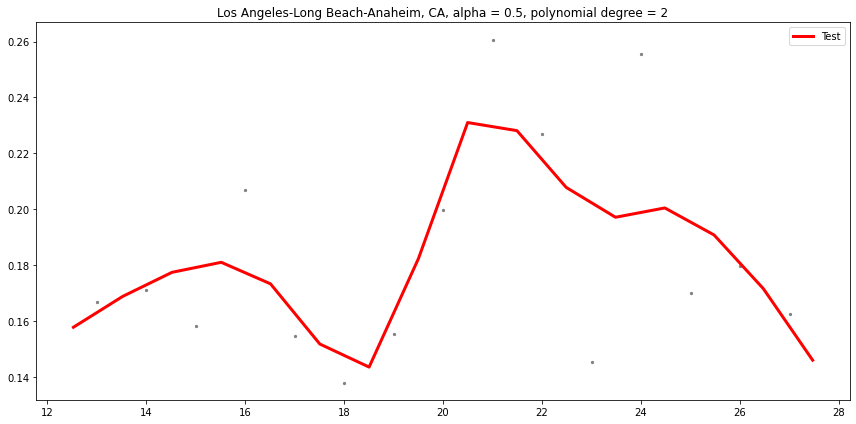

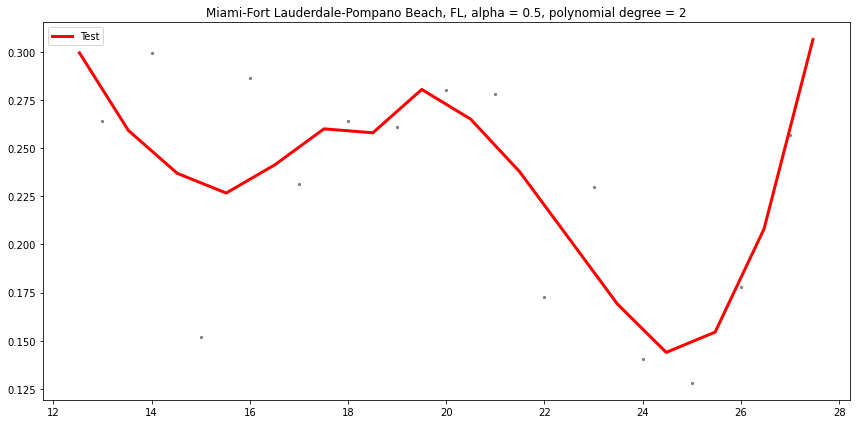

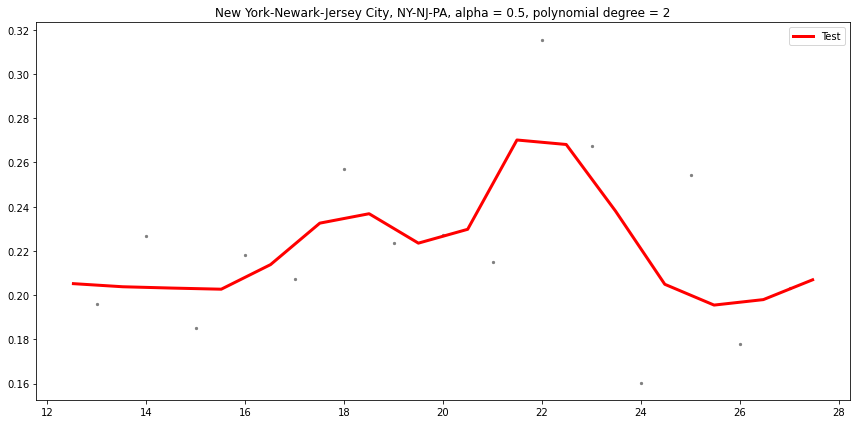

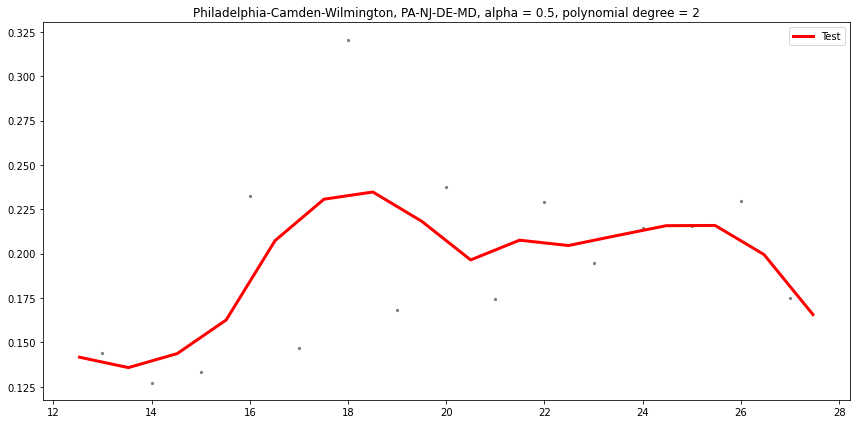

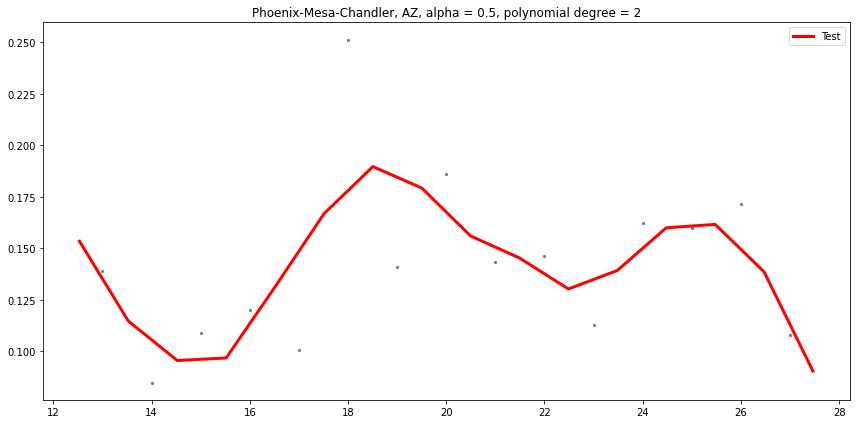

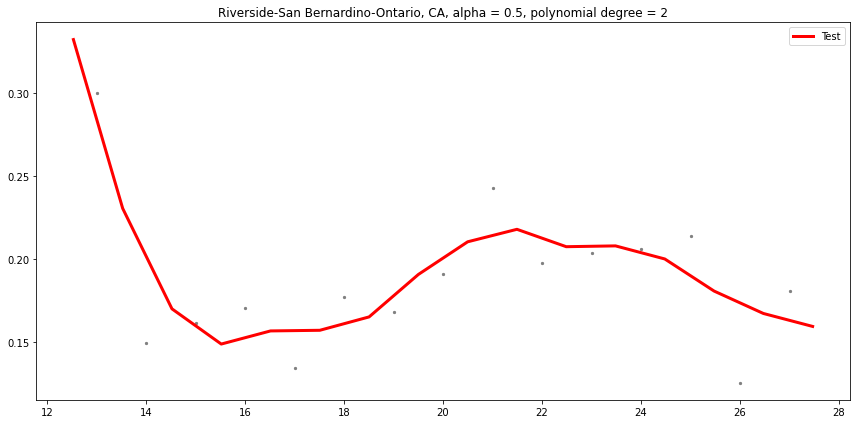

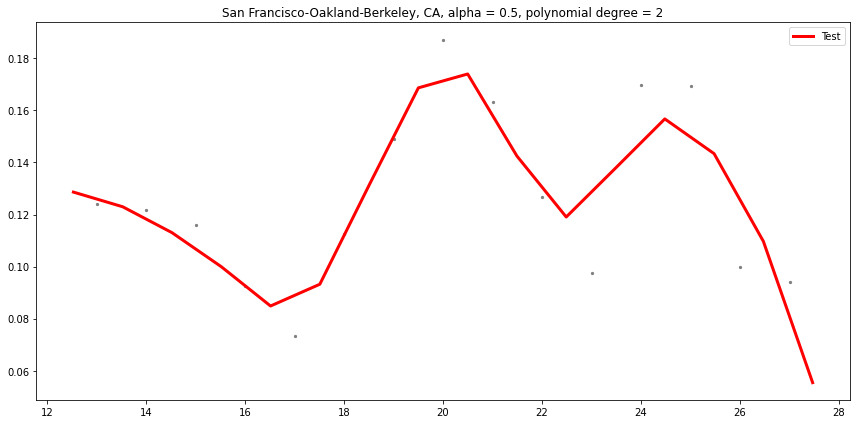

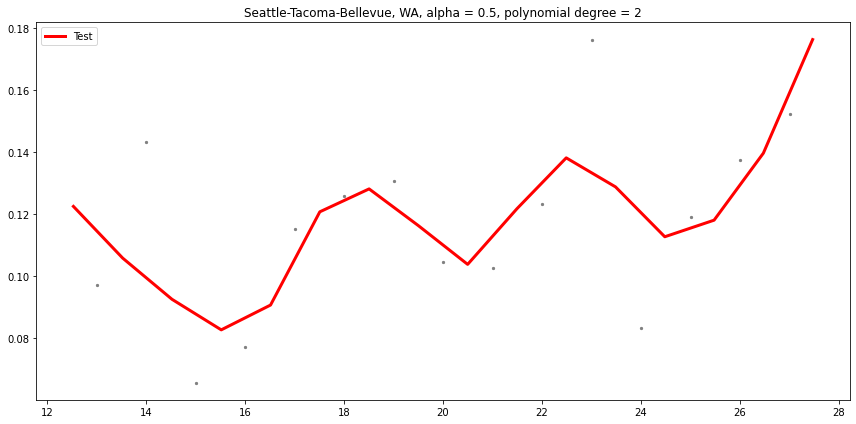

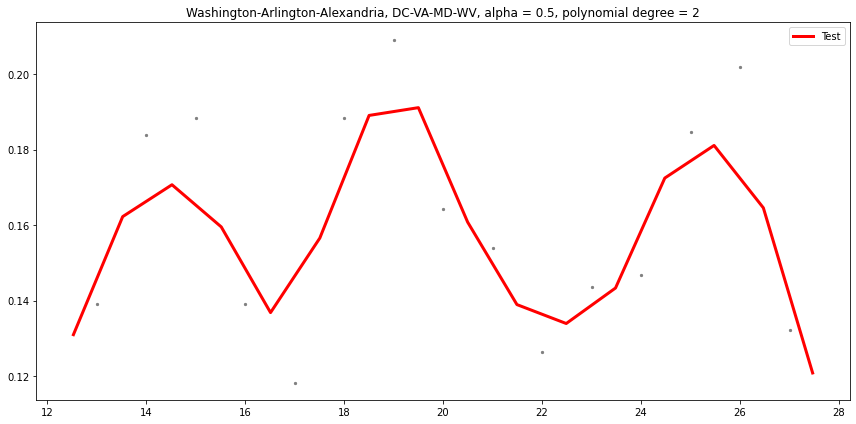

In [193]:
for i in raw.cbsa_title.unique():
    test = raw[(raw.q_var == 'RENTCUR') & (
        raw.ct_var=='TOPLINE') & (
            raw.cbsa_title==i) & (
                raw.q_val=='2 - Not currently caught up on rent')]

    x = test.WEEK
    y = test.proportions
    df = pd.DataFrame({"Xvalue" : x,
                        "Yvalue" : y
                        })

    evalDF = loess("Xvalue", "Yvalue", data = df, alpha=0.5, poly_degree=2)
    fig = plt.figure()
    plt.scatter(df["Xvalue"], df["Yvalue"], color="grey", marker="o", s=5, label="_nolegend_")
    plt.plot(evalDF['v'], evalDF['g'], color='red', linewidth= 3, label="Test")
    plt.title('{}, alpha = 0.5, polynomial degree = 2'.format(i))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [184]:
raw.head()

,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var,cbsa_title,description_recode,collection_dates
0,12060,13,1,1 - Married,2.232476e+06,98650.680548,98650.680548,4.487885e+06,91571.801376,91571.801376,0.497445,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,August 19 – August 31 2020
1,12060,13,1,2 - Unmarried or alone,2.255408e+06,101733.765949,101733.765949,4.487885e+06,91571.801376,91571.801376,0.502555,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,August 19 – August 31 2020
2,12060,14,1,1 - Married,2.376526e+06,79312.250074,79312.250074,4.559214e+06,120991.074737,120991.074737,0.521258,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,September 2 – September 14 2020
3,12060,14,1,2 - Unmarried or alone,2.182688e+06,109993.351717,109993.351717,4.559214e+06,120991.074737,120991.074737,0.478742,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,September 2 – September 14 2020
4,12060,15,1,1 - Married,2.401873e+06,98038.966807,98038.966807,4.465015e+06,112500.018255,112500.018255,0.537932,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,September 16 – September 28 2020


In [186]:
raw.shape

(1491324, 16)

In [188]:
raw[:100000]

,EST_MSA,WEEK,ct_val,q_val,PWEIGHT_full,std_err_full,mrgn_err_full,PWEIGHT_demo,std_err_demo,mrgn_err_demo,proportions,ct_var,q_var,cbsa_title,description_recode,collection_dates
0,12060,13,1,1 - Married,2.232476e+06,98650.680548,98650.680548,4.487885e+06,91571.801376,91571.801376,0.497445,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,August 19 – August 31 2020
1,12060,13,1,2 - Unmarried or alone,2.255408e+06,101733.765949,101733.765949,4.487885e+06,91571.801376,91571.801376,0.502555,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,August 19 – August 31 2020
2,12060,14,1,1 - Married,2.376526e+06,79312.250074,79312.250074,4.559214e+06,120991.074737,120991.074737,0.521258,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,September 2 – September 14 2020
3,12060,14,1,2 - Unmarried or alone,2.182688e+06,109993.351717,109993.351717,4.559214e+06,120991.074737,120991.074737,0.478742,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,September 2 – September 14 2020
4,12060,15,1,1 - Married,2.401873e+06,98038.966807,98038.966807,4.465015e+06,112500.018255,112500.018255,0.537932,TOPLINE,MS,"Atlanta-Sandy Springs-Alpharetta, GA",Marital status,September 16 – September 28 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,37980,26,"1 - Less than $25,000",2 - No expected household job loss,1.625907e+05,35061.489562,35061.489562,2.787747e+05,45691.552362,45691.552362,0.583233,INCOME,EXPCTLOSS,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Expect loss of household income in the next 4 ...,March 3 – March 15 2021
99996,37980,26,"2 - $25,000 - $34,999",1 - Expected household job loss,7.842208e+04,23152.332802,23152.332802,2.831563e+05,46163.860993,46163.860993,0.276957,INCOME,EXPCTLOSS,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Expect loss of household income in the next 4 ...,March 3 – March 15 2021
99997,37980,26,"2 - $25,000 - $34,999",2 - No expected household job loss,2.047342e+05,35803.726181,35803.726181,2.831563e+05,46163.860993,46163.860993,0.723043,INCOME,EXPCTLOSS,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Expect loss of household income in the next 4 ...,March 3 – March 15 2021
99998,37980,26,"3 - $35,000 - $49,999",1 - Expected household job loss,1.261805e+05,39225.568700,39225.568700,3.943839e+05,49571.541622,49571.541622,0.319943,INCOME,EXPCTLOSS,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Expect loss of household income in the next 4 ...,March 3 – March 15 2021


In [190]:
190600*16

3049600

In [192]:
'7' == 8

False

In [6]:
test.WEEK.min()

13